# Прогнозирование температуры звезд.

Обсерватория «Небо на ладони» хочет внедрить технологии машинного обучения для предсказания температуры звёзд.  

Заказчику важны:

- качество предсказания (RMSE < 4500).

<font color='green'>Цель</font>

Выбрать оптимальную модель нейронной сети для предсказания температуры.

<font color='green'>Задачи</font>

- исследовать данные;
- подготовить данные;
- создать модель нейронной сети;
- оптимизировать модель;

<font color='green'>Файлы</font>

- `6_class.csv`

<font color='green'>Признаки</font>

- `Luminosity(L/Lo)` — светимость звезды относительно Солнца;
- `Radius(R/Ro)` — радиус звезды относительно радиуса Солнца;
- `Absolute magnitude(Mv)` — блеск звезды;
- `Star type` — тип звезды;
- `Star color` — цвет звезды, который определяют на основе спектрального анализа;

<font color='green'>Целевой признак</font>

- `Temperature (K)` - температура на поверхности звезды в Кельвинах.

<font color='green'>Содержание</font>

<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1">Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-знакомство-с-данными" data-toc-modified-id="Загрузка-и-знакомство-с-данными-1.1">Загрузка и знакомство с данными</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.2">Анализ данных</a></span></li><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-1.3">Разделение данных на выборки</a></span></li><li><span><a href="#OHE-и-масштабирование-признаков" data-toc-modified-id="OHE-и-масштабирование-признаков-1.4">OHE и масштабирование признаков</a></span></li></ul></li><li><span><a href="#Построение-базовой-нейронной-сети" data-toc-modified-id="Построение-базовой-нейронной-сети-2">Построение базовой нейронной сети</a></span></li><li><span><a href="#Изменение-модели" data-toc-modified-id="Изменение-модели-3">Изменение модели</a></span><ul class="toc-item"><li><span><a href="#Вариант-1:-использование-валидационной-выборки." data-toc-modified-id="Вариант-1:-использование-валидационной-выборки.-3.1">Вариант 1: использование валидационной выборки.</a></span></li><li><span><a href="#Вариант-2:-использование-NeuralNetRegressor." data-toc-modified-id="Вариант-2:-использование-NeuralNetRegressor.-3.2">Вариант 2: использование NeuralNetRegressor.</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4">Выводы</a></span></li></ul></div>

## Подготовка данных

### Загрузка и знакомство с данными

In [1]:
import pandas as pd
import numpy as np
from modelsummary import summary
from math import ceil

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import  mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn


import skorch
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor

import random
def set_random_seed(seed):
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)    
        random.Random(seed) # для dropout
set_random_seed(12345)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # для RandomizedSearchCV

In [2]:
data = pd.read_csv('/ML/datasets/6_class.csv', index_col=0)

In [3]:
data.sample(10, random_state=42)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
24,16500,0.01300,0.01400,11.89,2,Blue White
6,2637,0.00073,0.12700,17.22,0,Red
93,4980,0.35700,1.13000,4.78,3,Yellowish
109,33421,352000.00000,67.00000,-5.79,4,Blue
104,11096,112000.00000,12.00000,-5.91,4,Blue
172,4287,630000.00000,1315.00000,-9.20,5,Orange
233,27739,849420.00000,1252.00000,-7.59,5,Blue-white
86,12010,0.00078,0.00920,12.13,2,Blue White
9,2700,0.00018,0.13000,16.05,0,Red
143,14520,0.00082,0.00972,11.92,2,Blue White


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [5]:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


### Анализ данных

In [6]:
#report = sv.analyze(data)
#report.show_html()

Дубликатов и пропущенных значений в данных не выявлено. Распределение целевой велечины имеет длинный правый "хвост". В столбце `'Star color'` есть проблемы с наименованием типов. Присутствует сильная зависимость между `'Star type'`и `'Radius(R/Ro)'` / `'Absolute magnitude(Mv)'`.  

Приведем данные в столбце `'Star color'` к нижнему регистру и удалим пробелы.

In [7]:
data['Star color'] = data['Star color'].str.strip()
data['Star color'] = data['Star color'].str.lower()

In [8]:
data['Star color'].value_counts()

red                   112
blue                   56
blue-white             27
blue white             14
white                  10
yellow-white            8
yellowish white         3
yellowish               3
whitish                 2
orange                  2
pale yellow orange      1
white-yellow            1
orange-red              1
Name: Star color, dtype: int64

Укрупним категории.

In [9]:
data['Star color'] = data['Star color'].replace(to_replace=['blue-white', 'blue white'], value='blue')
data['Star color'] = data['Star color'].replace(to_replace=['yellow-white', 'yellowish', 'yellowish white', 'white-yellow'],\
                                                            value='yellow')
data['Star color'] = data['Star color'].replace(to_replace=['orange', 'orange-red', 'pale yellow orange'], value='orange')
data['Star color'] = data['Star color'].replace(to_replace=['whitish'], value='white')

In [10]:
data['Star color'].value_counts()

red       112
blue       97
yellow     15
white      12
orange      4
Name: Star color, dtype: int64

Посмотрим на целевую переменную.

Text(0.5, 0, 'Температура (K)')

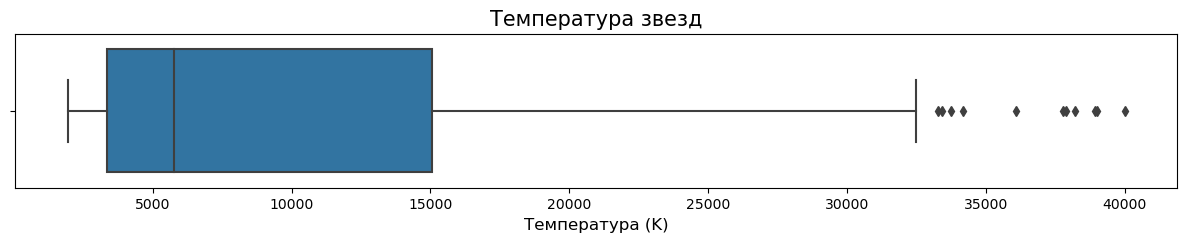

In [11]:
plt.figure(figsize=(15, 2))
ax = sns.boxplot(x=data['Temperature (K)']);
ax.set_title('Температура звезд', fontsize=15)
ax.set_xlabel('Температура (K)', fontsize=12)

In [12]:
data.loc[data['Temperature (K)'] > 35000, 'Temperature (K)'].count()

7

### Разделение данных на выборки

Выделим признаки и целевой признак. 

In [13]:
features = data.drop(['Temperature (K)'], axis=1)
target = data['Temperature (K)']

Разделим данные на выборки.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Проверим размеры полученных файлов.

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(180, 5) (180,) (60, 5) (60,)


###  OHE и масштабирование признаков

Разделим колонки на два типа: числовые и категориальные.

In [16]:
categorical = ['Star type', 'Star color']
targ = ['Temperature (K)']
numerical = [col for col in data.columns if col not in categorical+targ]

Применим к данным OneHotEncoder и StandardScaler.

In [17]:
preprocessor = ColumnTransformer(transformers=[('standardscaler', StandardScaler(), numerical),
                                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'), categorical)
])

In [18]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

**Вывод**

Дубликатов и пропущенных значений в данных не выявлено. 

Укрупнены категории в столбце `'Star color'`. 

## Построение базовой нейронной сети

Гиперпараметры обучения:

In [19]:
num_epochs = 500
learning_rate = 0.07

Функция для инициализации параметров:

In [20]:
def init_weights(layer):
    
    if type(layer) == nn.Linear: 
        nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
        nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 

In [21]:
X_train_tensor = torch.FloatTensor(X_train) 
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

In [22]:
results_loss_1 = [] 
results_time_1 = [] 
results_loss_2 = [] 

n_in_neurons = X_train_tensor.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)

net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [23]:
%%time

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train_tensor).flatten()
     
    loss_value = loss(preds, y_train_tensor)
    loss_value.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():   
                net.eval()
                test_preds = net.forward(X_test_tensor).flatten()
                loss_value_test = loss(test_preds, y_test_tensor) 
                print('epoch {}, RMSE train {:.4f}, RMSE test {:.4f}'.format(epoch, torch.Tensor.sqrt_(loss_value),\
                                                                             torch.Tensor.sqrt_(loss_value_test)))                
              
                results_loss_1.append(loss_value.tolist())
                results_time_1.append(epoch)
                results_loss_2.append(loss_value_test.tolist())
                
       
print('')
print('Лучшее значение RMSE train: ', min(results_loss_1))
print('Лучшее значение RMSE test: ', min(results_loss_2))

epoch 0, RMSE train 13716.8750, RMSE test 15442.5361
epoch 10, RMSE train 13590.1504, RMSE test 15286.5400
epoch 20, RMSE train 13216.7197, RMSE test 14827.7891
epoch 30, RMSE train 12332.5410, RMSE test 13776.7441
epoch 40, RMSE train 10815.9580, RMSE test 12099.5928
epoch 50, RMSE train 9224.5391, RMSE test 10504.3711
epoch 60, RMSE train 8223.5352, RMSE test 9338.2295
epoch 70, RMSE train 7063.3096, RMSE test 7968.9761
epoch 80, RMSE train 6319.5615, RMSE test 7093.0894
epoch 90, RMSE train 5831.5273, RMSE test 6530.1377
epoch 100, RMSE train 5478.1152, RMSE test 6253.4653
epoch 110, RMSE train 5160.2104, RMSE test 6050.3071
epoch 120, RMSE train 4862.0591, RMSE test 5894.0845
epoch 130, RMSE train 4656.2798, RMSE test 5871.1079
epoch 140, RMSE train 4547.4590, RMSE test 5889.7549
epoch 150, RMSE train 4482.6631, RMSE test 5908.0010
epoch 160, RMSE train 4437.5879, RMSE test 5923.4692
epoch 170, RMSE train 4400.9497, RMSE test 5926.2363
epoch 180, RMSE train 4369.8696, RMSE test 591

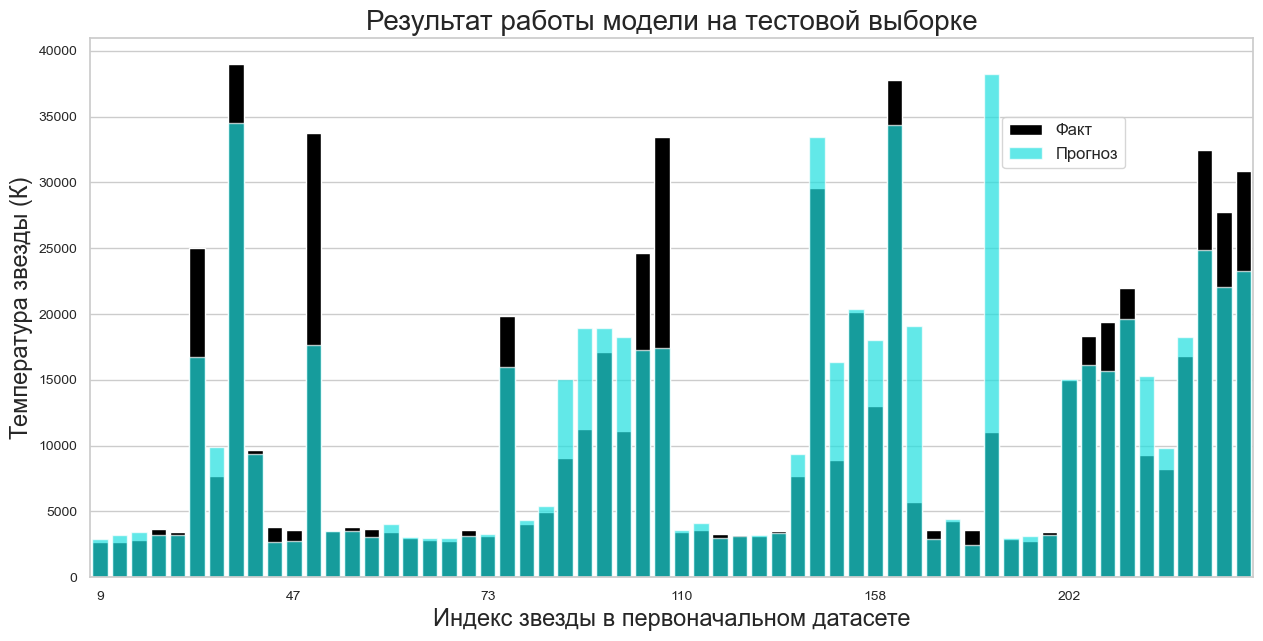

In [24]:
x = pd.concat([y_test.reset_index(), pd.Series(test_preds.flatten().detach().numpy())], axis=1)

sns.set(style="whitegrid")
fig_1=plt.figure(1, figsize=(15, 7))


sns.barplot(data=x, x='index', y='Temperature (K)', color ='black', alpha = 1, label='Факт')
sns.barplot(data=x, x='index', y=0, color ='cyan', alpha = 0.7, label='Прогноз')

plt.xticks(ticks=np.arange(0, len(x), 10), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('Индекс звезды в первоначальном датасете', fontsize=17)
plt.ylabel('Температура звезды (К)', fontsize=17)
plt.title('Результат работы модели на тестовой выборке', fontsize=20)
plt.draw()

**Вывод**

In [25]:
print('Лучшее значение RMSE test: ', round(min(results_loss_2), 2))

Лучшее значение RMSE test:  5813.54


Архитектура модели:

In [26]:
summary(net, torch.zeros(5, 14), show_input=False) 

-----------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
                 Linear-1                   [-1, 10]             150
                    ELU-2                   [-1, 10]               0
                 Linear-3                   [-1, 10]             110
                    ELU-4                   [-1, 10]               0
                 Linear-5                    [-1, 1]              11
                   ReLU-6                    [-1, 1]               0
Total params: 271
Trainable params: 271
Non-trainable params: 0
-----------------------------------------------------------------------


Модель плохо предсказывает значения температуры выше 20 000 К. 

## Изменение модели

###  Вариант 1: использование валидационной выборки.

In [27]:
X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(
    X_train, y_train, test_size=0.25, random_state=12345)

print(X_train_n.shape, y_train_n.shape, X_valid_n.shape, y_valid_n.shape)

X_train_n_tensor = torch.FloatTensor(X_train_n) 
X_valid_n_tensor = torch.FloatTensor(X_valid_n)
y_train_n_tensor = torch.FloatTensor(y_train_n.values)
y_valid_n_tensor = torch.FloatTensor(y_valid_n.values)

(135, 14) (135,) (45, 14) (45,)


In [28]:
batch_size = [8, 16, 24, 32]

def init_weights_n(layer):
    
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 
        nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 
        
results_loss_3 = []
results_time_3 = []
results_size_3 = []

n_in_neurons = X_train_n_tensor.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

net_2 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_1),    
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_2),    
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)        

In [29]:
%%time

for size in batch_size:
        
        net_2.apply(init_weights_n)
        optimizer = torch.optim.Adam(net_2.parameters(), lr=learning_rate)
        loss = nn.MSELoss()
        num_batches = ceil(len(X_train_n)/size)
                
        for epoch in range(num_epochs):
            order = np.random.permutation(len(X_train_n)) 
            for batch_idx in range(num_batches):
        
                start_index = batch_idx * size 
                net_2.train()                                              # новый код
                optimizer.zero_grad()
        
                batch_indexes = order[start_index:start_index+size] 
                X_batch = X_train_n_tensor[batch_indexes]
                y_batch = y_train_n_tensor[batch_indexes]
        
                preds = net_2.forward(X_batch).flatten()
          
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()

            if epoch % 10 == 0 or epoch == num_epochs - 1:
                
                with torch.no_grad():                                     # новый код
                
                    net_2.eval()
                    test_preds = net_2.forward(X_valid_n_tensor).flatten()
                    loss_value_valid = loss(test_preds, y_valid_n_tensor)
                    print('size {}, epoch {}, RMSE train {:.4f}, RMSE valid {:.4f}'.format(size, epoch, \
                                                        torch.Tensor.sqrt_(loss_value), torch.Tensor.sqrt_(loss_value_valid)))  
                    results_loss_3.append(loss_value_valid.tolist())
                    results_time_3.append(epoch)
                    results_size_3.append(size)

index = results_loss_3.index(min(results_loss_3))
print('')
print('Лучшее значение RMSE valid: size {}, epoch {}, RMSE {:.4f}'.format(results_size_3[index], \
                                                                              results_time_3[index], min(results_loss_3))) 

size 8, epoch 0, RMSE train 16026.3398, RMSE valid 14883.4883
size 8, epoch 10, RMSE train 6257.7104, RMSE valid 10454.1055
size 8, epoch 20, RMSE train 5635.1406, RMSE valid 5778.4922
size 8, epoch 30, RMSE train 6197.3511, RMSE valid 4919.5366
size 8, epoch 40, RMSE train 4907.3843, RMSE valid 4767.2100
size 8, epoch 50, RMSE train 2675.7930, RMSE valid 4808.6309
size 8, epoch 60, RMSE train 5596.1133, RMSE valid 4439.1323
size 8, epoch 70, RMSE train 7039.6270, RMSE valid 5626.3013
size 8, epoch 80, RMSE train 4220.5508, RMSE valid 5360.6968
size 8, epoch 90, RMSE train 3353.7219, RMSE valid 4479.8350
size 8, epoch 100, RMSE train 2681.8398, RMSE valid 4480.8633
size 8, epoch 110, RMSE train 2366.9736, RMSE valid 4583.5918
size 8, epoch 120, RMSE train 8561.0303, RMSE valid 4353.2163
size 8, epoch 130, RMSE train 5615.0713, RMSE valid 4325.5122
size 8, epoch 140, RMSE train 3351.8513, RMSE valid 4287.4956
size 8, epoch 150, RMSE train 3000.2100, RMSE valid 4637.0215
size 8, epoch 16

size 24, epoch 300, RMSE train 3876.9729, RMSE valid 4599.5190
size 24, epoch 310, RMSE train 5123.8052, RMSE valid 4311.0806
size 24, epoch 320, RMSE train 3846.2310, RMSE valid 4223.6143
size 24, epoch 330, RMSE train 3066.9719, RMSE valid 4090.9495
size 24, epoch 340, RMSE train 1540.9631, RMSE valid 4217.3291
size 24, epoch 350, RMSE train 3601.5762, RMSE valid 4104.6030
size 24, epoch 360, RMSE train 3077.8806, RMSE valid 4131.4634
size 24, epoch 370, RMSE train 1738.0963, RMSE valid 4270.8584
size 24, epoch 380, RMSE train 3318.6992, RMSE valid 4249.3877
size 24, epoch 390, RMSE train 1900.2872, RMSE valid 4424.3662
size 24, epoch 400, RMSE train 5122.9756, RMSE valid 4268.0381
size 24, epoch 410, RMSE train 1512.4523, RMSE valid 4228.2603
size 24, epoch 420, RMSE train 1964.5369, RMSE valid 4321.3979
size 24, epoch 430, RMSE train 4401.6255, RMSE valid 4368.4844
size 24, epoch 440, RMSE train 4819.7017, RMSE valid 4145.5825
size 24, epoch 450, RMSE train 4594.7393, RMSE valid 41

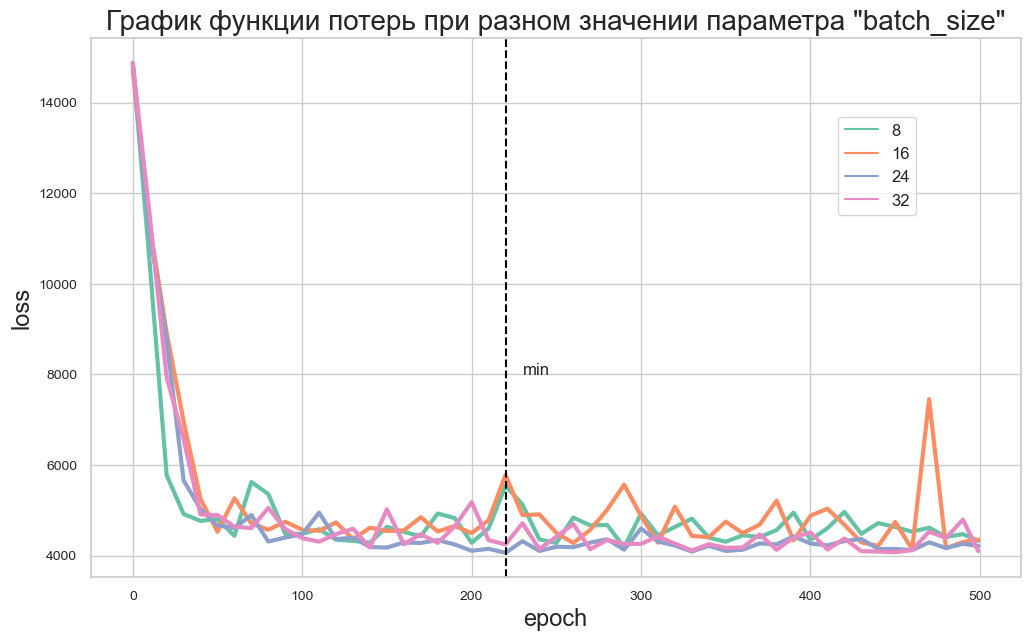

In [30]:
y = pd.concat([pd.Series(results_size_3), pd.Series(results_time_3), pd.Series(results_loss_3)], axis=1) 
y.columns = ['batch_size', 'epoch', 'loss']

sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(data=y, x='epoch', y='loss', hue='batch_size', palette="Set2", linewidth = 3.0)
plt.axvline(results_time_3[index], 0,1.0, color = 'black', linestyle='--')
plt.text (results_time_3[index]+10, 8000, 'min')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('epoch', fontsize=17)
plt.ylabel('loss', fontsize=17)
plt.title('График функции потерь при разном значении параметра "batch_size"', fontsize=20)
plt.show();

In [31]:
print('Лучшее значение RMSE valid: size {}, epoch {}, RMSE {:.4f}'.format(results_size_3[index], results_time_3[index],\
                                                                              min(results_loss_3))) 

Лучшее значение RMSE valid: size 24, epoch 220, RMSE 4064.1099


На основе полученных данных сформируем новую модель. 

In [32]:
num_epochs = results_time_3[index]
batch_size = results_size_3[index]
num_epochs = results_time_3[index]
batch_size = results_size_3[index]


results_loss_4 = [] 
results_time_4 = [] 
results_loss_5 = [] 

n_in_neurons = X_train_n_tensor.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

net_3 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_1),    
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_2),    
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)

net_3.apply(init_weights_n)
optimizer = torch.optim.Adam(net_3.parameters(), lr=learning_rate)
loss = nn.MSELoss()

num_batches = ceil(len(X_train_n)/batch_size)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train_n)) 
    
    for batch_idx in range(num_batches):
        
        start_index = batch_idx * batch_size 
        net_3.train()                                              
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size] 
        X_batch = X_train_n_tensor[batch_indexes]
        y_batch = y_train_n_tensor[batch_indexes]
        
        preds = net_3.forward(X_batch).flatten()
          
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            net_3.eval()
            test_preds = net_3.forward(X_test_tensor).flatten()
            loss_value_test = loss(test_preds, y_test_tensor)
            print('epoch {}, RMSE valid {:.4f}, RMSE test {:.4f}'.format(epoch, torch.Tensor.sqrt_(loss_value), \
                                                                     torch.Tensor.sqrt_(loss_value_test)))
            results_loss_4.append(loss_value_test.tolist())
            results_loss_5.append(loss_value.tolist())
            results_time_4.append(epoch)

print('')
print('Лучшее значение RMSE valid: ', min(results_loss_5))
print('Лучшее значение RMSE test: ', min(results_loss_4))

epoch 0, RMSE valid 9915.1709, RMSE test 15450.1631
epoch 10, RMSE valid 7845.4785, RMSE test 14801.1455
epoch 20, RMSE valid 11578.9600, RMSE test 12874.3750
epoch 30, RMSE valid 9863.2012, RMSE test 10408.5107
epoch 40, RMSE valid 2573.2051, RMSE test 7914.1631
epoch 50, RMSE valid 3492.8010, RMSE test 6201.7549
epoch 60, RMSE valid 5576.4561, RMSE test 5230.5293
epoch 70, RMSE valid 3285.3379, RMSE test 5369.7539
epoch 80, RMSE valid 3425.3159, RMSE test 5426.3267
epoch 90, RMSE valid 4078.3894, RMSE test 5797.1987
epoch 100, RMSE valid 4112.7686, RMSE test 4985.1118
epoch 110, RMSE valid 5669.6411, RMSE test 4989.4932
epoch 120, RMSE valid 4712.9736, RMSE test 4991.2993
epoch 130, RMSE valid 6531.9116, RMSE test 4968.4888
epoch 140, RMSE valid 5357.1484, RMSE test 4904.9072
epoch 150, RMSE valid 2865.6406, RMSE test 5028.7852
epoch 160, RMSE valid 7014.4634, RMSE test 5104.6504
epoch 170, RMSE valid 5087.6724, RMSE test 4932.7607
epoch 180, RMSE valid 3989.0481, RMSE test 4885.4771

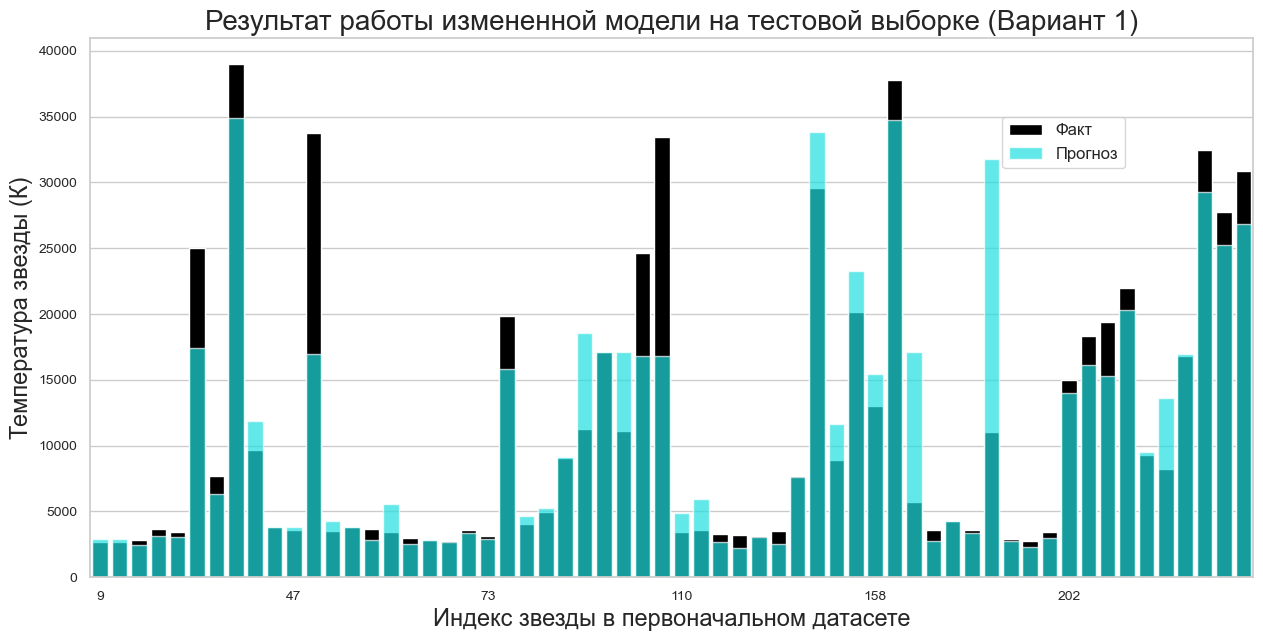

In [33]:
y = pd.concat([y_test.reset_index(), pd.Series(test_preds.flatten().detach().numpy())], axis=1)

sns.set(style="whitegrid")
fig_2 = plt.figure(1, figsize=(15, 7))

sns.barplot(data=y, x='index', y='Temperature (K)', color ='black', alpha = 1, label='Факт')
sns.barplot(data=y, x='index', y=0, color ='cyan', alpha = 0.7, label='Прогноз')

plt.xticks(ticks=np.arange(0, len(x), 10), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('Индекс звезды в первоначальном датасете', fontsize=17)
plt.ylabel('Температура звезды (К)', fontsize=17)
plt.title('Результат работы измененной модели на тестовой выборке (Вариант 1)', fontsize=20)
plt.draw()

###  Вариант 2: использование NeuralNetRegressor.

In [34]:
class Model_improve(nn.Module):
    def __init__(self, n_hidden_neurons_1=10, n_hidden_neurons_2=10, activation_1=nn.ELU(), activation_2=nn.ELU(), 
                 activation_3=nn.ReLU(), dropout_1=0, dropout_2=0, optimizer=torch.optim.Adam):
        super(Model_improve, self).__init__()
        
        
        self.layer1 = nn.Linear(14, n_hidden_neurons_1)
        self.act1 = activation_1 
        #self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dp1 = nn.Dropout(dropout_1)
        
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation_2    
        #self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.dp2 = nn.Dropout(dropout_2)
        
        self.layer3 = nn.Linear(n_hidden_neurons_2, 1)
        self.act3 = activation_3    
        
        self.layer_names = ['layer1', 'layer2', 'layer3']
        self.optimizer = optimizer
        
    def init_weights(self):
        for layer in self.layer_names:
            if type(layer) == nn.Linear: 
                nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
                nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 
    
    def zero_grad_optimizer(self, set_to_none=None):
        
            if set_to_none is None:
                optimizer.zero_grad()
            else:
                optimizer.zero_grad(set_to_none=set_to_none)
       
    def forward(self, x):
        
        self.init_weights()
        self.zero_grad_optimizer()
        
        x = self.layer1(x)
        x = self.act1(x)
        #x = self.bn1(x)
        x = self.dp1(x)
        
        x = self.layer2(x)
        x = self.act2(x)
        #x = self.bn2(x)
        x = self.dp2(x)
        
        x = self.layer3(x)
        x = self.act3(x)
        return x    

In [35]:
%%time

scorers = make_scorer(mean_squared_error, squared=False) 

skorch_regressor = NeuralNetRegressor(module=Model_improve, 
                                      device='cpu',  
                                      verbose=0,
                                      batch_size=8,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=500, 
                                      lr=0.07,
                                      train_split=skorch.dataset.ValidSplit(5), 
                                      criterion=torch.nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=scorers, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=5)),
            ],
                                     ) 

params = {
     
    'module__n_hidden_neurons_1': [4, 5, 10],
    'module__n_hidden_neurons_2': [4, 5, 10],
        
    'module__dropout_1': [0, 0.1],
    'module__dropout_2': [0, 0.1],
    
    'module__activation_1': [nn.ReLU(), nn.ELU()],
    'module__activation_2': [nn.ReLU(), nn.ELU()],
    'module__activation_3': [nn.ReLU(), nn.ELU()],
        
    #'optimizer__lr': [0.001, 0.01, 0.05, 0.07],
    'lr': [0.001, 0.01, 0.05, 0.07],
    'batch_size': [8, 16, 24, 32]
}

grid_search = RandomizedSearchCV(skorch_regressor, params, cv=5, scoring='neg_root_mean_squared_error', verbose=0, n_iter=100) 
grid_search.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 
print()
print("Параметры лучшей модели:", grid_search.best_params_)


Параметры лучшей модели: {'module__n_hidden_neurons_2': 5, 'module__n_hidden_neurons_1': 5, 'module__dropout_2': 0.1, 'module__dropout_1': 0, 'module__activation_3': ELU(alpha=1.0), 'module__activation_2': ReLU(), 'module__activation_1': ELU(alpha=1.0), 'lr': 0.07, 'batch_size': 16}
CPU times: total: 30min 11s
Wall time: 8min 13s


In [36]:
train_preds = grid_search.best_estimator_.predict(X_train_tensor)
test_preds = grid_search.best_estimator_.predict(X_test_tensor)

print("Лучшее значение RMSE train: {:.3f}".format(mean_squared_error(y_train, train_preds, squared=False))) 
print("Лучшее значение RMSE test: {:.3f}".format(mean_squared_error(y_test, test_preds, squared=False)))  
print()

Лучшее значение RMSE train: 4543.116
Лучшее значение RMSE test: 5849.021



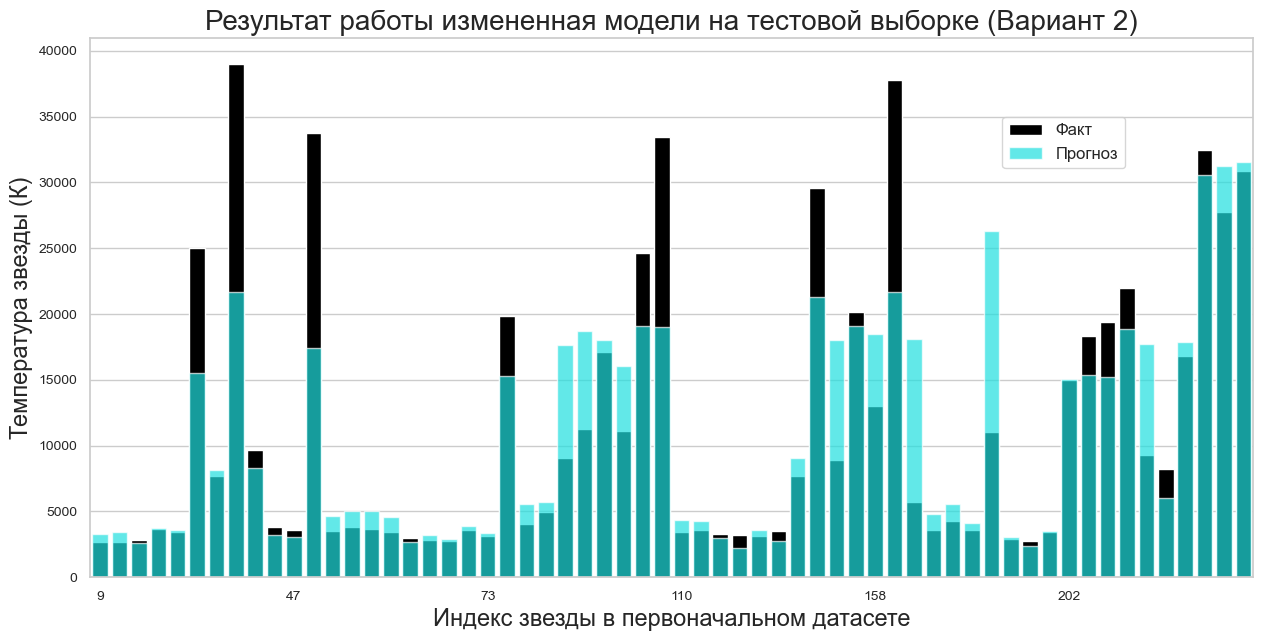

In [37]:
z = pd.concat([y_test.reset_index(), pd.Series(test_preds.flatten())], axis=1)

sns.set(style="whitegrid")
fig_3 = plt.figure(1, figsize=(15, 7))

sns.barplot(data=z, x='index', y='Temperature (K)', color ='black', alpha = 1, label='Факт')
sns.barplot(data=z, x='index', y=0, color ='cyan', alpha = 0.7, label='Прогноз')

plt.xticks(ticks=np.arange(0, len(x), 10), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('Индекс звезды в первоначальном датасете', fontsize=17)
plt.ylabel('Температура звезды (К)', fontsize=17)
plt.title('Результат работы измененная модели на тестовой выборке (Вариант 2)', fontsize=20)
plt.draw()

## Выводы

In [38]:
print('Лучшее значение RMSE train (Первоначальная модель)       : ', round(min(results_loss_1), 2))
print('Лучшее значение RMSE test  (Первоначальная модель)       : ', round(min(results_loss_2), 2))
print()
print('Лучшее значение RMSE valid (Измененная модель Вариант 1) : ', round(min(results_loss_5), 2))
print('Лучшее значение RMSE test  (Измененная модель Вариант 1) : ', round(min(results_loss_4), 2))
print()
print('Лучшее значение RMSE train (Измененная модель Вариант 2) : ', round(mean_squared_error(y_train, train_preds, squared=False), 2))
print('Лучшее значение RMSE test  (Измененная модель Вариант 2) : ', round(mean_squared_error(y_test, test_preds, squared=False), 2))
print()
print("Параметры лучшей модели:", grid_search.best_params_)

Лучшее значение RMSE train (Первоначальная модель)       :  3668.6
Лучшее значение RMSE test  (Первоначальная модель)       :  5813.54

Лучшее значение RMSE valid (Измененная модель Вариант 1) :  2573.21
Лучшее значение RMSE test  (Измененная модель Вариант 1) :  4885.48

Лучшее значение RMSE train (Измененная модель Вариант 2) :  4543.12
Лучшее значение RMSE test  (Измененная модель Вариант 2) :  5849.02

Параметры лучшей модели: {'module__n_hidden_neurons_2': 5, 'module__n_hidden_neurons_1': 5, 'module__dropout_2': 0.1, 'module__dropout_1': 0, 'module__activation_3': ELU(alpha=1.0), 'module__activation_2': ReLU(), 'module__activation_1': ELU(alpha=1.0), 'lr': 0.07, 'batch_size': 16}


Изменения в модели (Вариант 1):

    - обучение модели батчами (batch);
    - для весов применена инициализация Кайминга;
    - использован метод регуляризации BatchNorm;  
    
Изменения в модели (Вариант 2):

    - подбор параметров с помощью RandomizedSearchCV
    - обучение модели батчами (batch);
    - использован метод регуляризации Dropout;

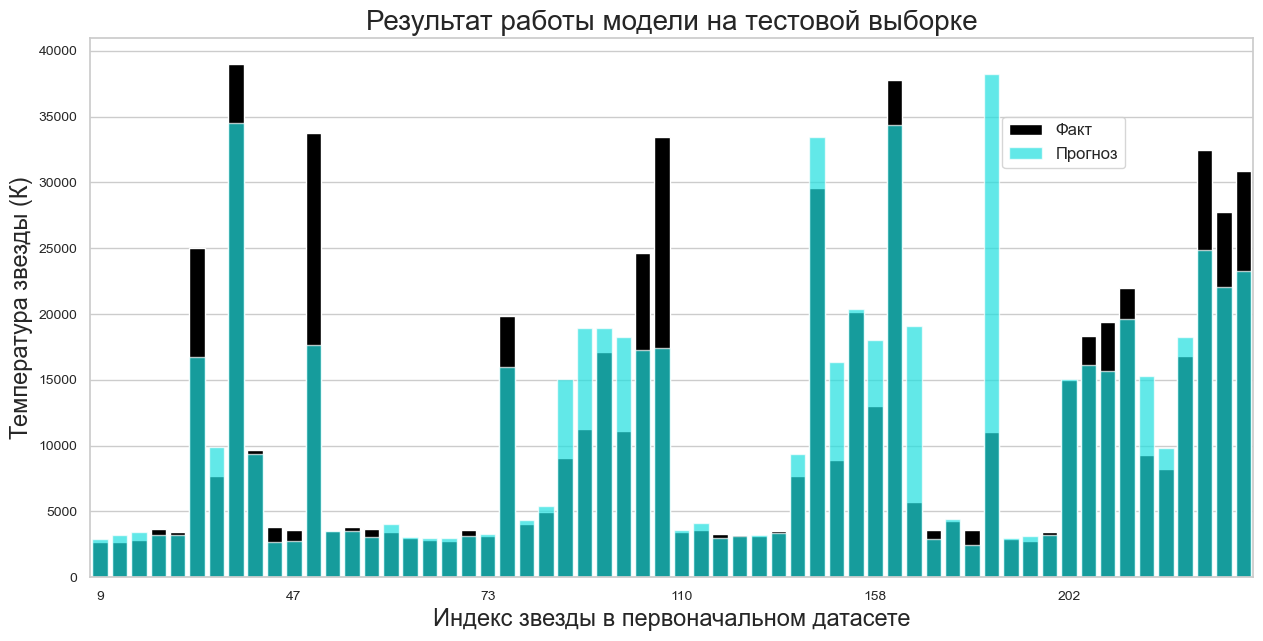

In [39]:
fig_1

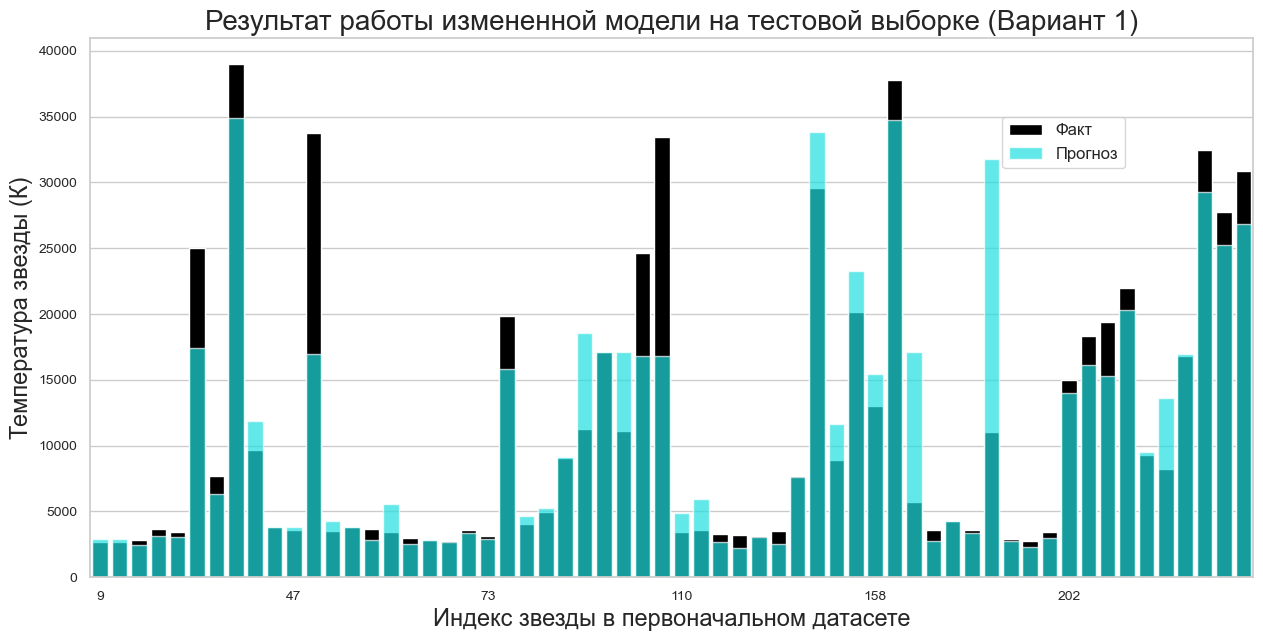

In [40]:
fig_2

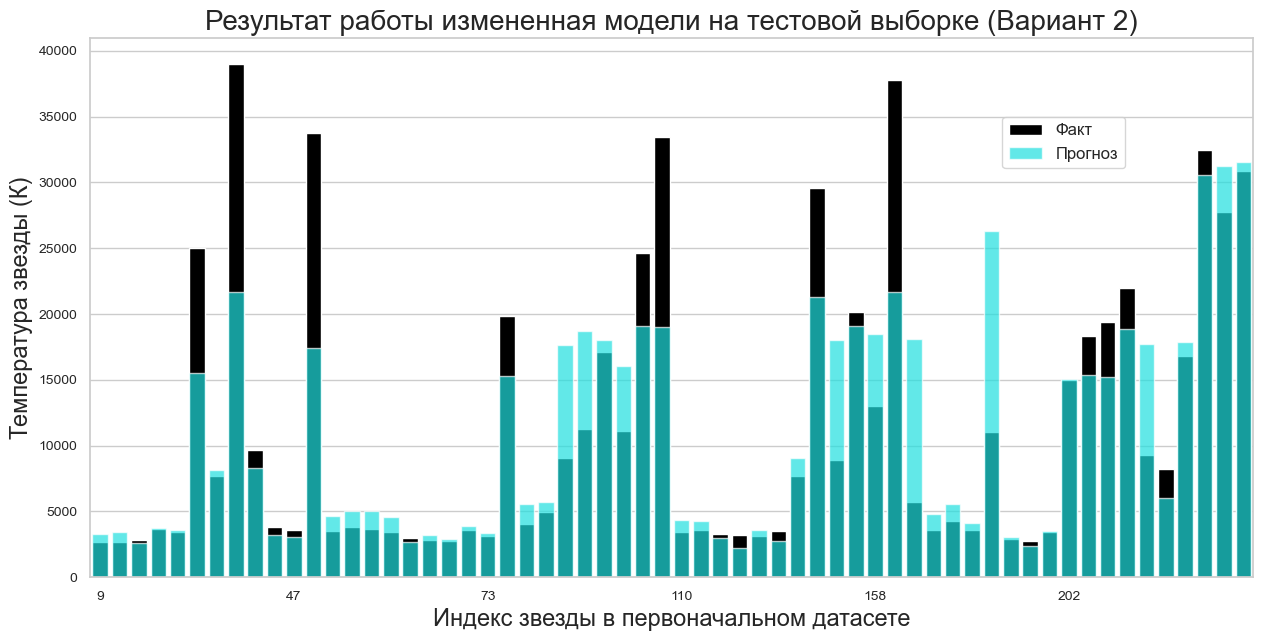

In [41]:
fig_3